## Section 3: Q-learning

Original notebooks: https://github.com/yandexdataschool/Practical_RL/tree/master/week03_model_free

This notebook will guide you through implementation of vanilla Q-learning algorithm.

You need to implement QLearningAgent (follow instructions for each method) and use it on a number of tests below.

In [1]:
import sys, os
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash

    !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

Selecting previously unselected package xvfb.
(Reading database ... 123991 files and directories currently installed.)
Preparing to unpack .../xvfb_2%3a1.19.6-1ubuntu4.11_amd64.deb ...
Unpacking xvfb (2:1.19.6-1ubuntu4.11) ...
Setting up xvfb (2:1.19.6-1ubuntu4.11) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Starting virtual X frame buffer: Xvfb.


In [2]:
!pip install gymnasium
!pip install gymnasium[classic_control]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 836 kB 4.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 18.3 MB 2.0 MB/s 


In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [267]:
from collections import defaultdict
import random
import math
import numpy as np


class QLearningAgent:
    def __init__(self, alpha, epsilon, discount, get_legal_actions):
        """
        Q-Learning Agent
        based on https://inst.eecs.berkeley.edu/~cs188/sp19/projects.html
        Instance variables you have access to
          - self.epsilon (exploration prob)
          - self.alpha (learning rate)
          - self.discount (discount rate aka gamma)

        Functions you should use
          - self.get_legal_actions(state) {state, hashable -> list of actions, each is hashable}
            which returns legal actions for a state
          - self.get_qvalue(state,action)
            which returns Q(state,action)
          - self.set_qvalue(state,action,value)
            which sets Q(state,action) := value
        !!!Important!!!
        Note: please avoid using self._qValues directly. 
            There's a special self.get_qvalue/set_qvalue for that.
        """

        self.get_legal_actions = get_legal_actions
        self._qvalues = defaultdict(lambda: defaultdict(lambda: 0))
        self.alpha = alpha
        self.epsilon = epsilon
        self.discount = discount

    def get_qvalue(self, state, action):
        """ Returns Q(state,action) """
        return self._qvalues[state][action]

    def set_qvalue(self, state, action, value):
        """ Sets the Qvalue for [state,action] to the given value """
        self._qvalues[state][action] = value

    #---------------------START OF YOUR CODE---------------------#

    def get_value(self, state):
        """
        Compute your agent's estimate of V(s) using current q-values
        V(s) = max_over_action Q(state,action) over possible actions.
        Note: please take into account that q-values can be negative.
        """
        possible_actions = self.get_legal_actions(state)

        # If there are no legal actions, return 0.0
        if not possible_actions:
            return 0.0

        value = np.max([self.get_qvalue(state, 
                                        action) for action in possible_actions])

        return value

    def update(self, state, action, reward, next_state):
        """
        You should do your Q-Value update here:
           Q(s,a) := (1 - alpha) * Q(s,a) + alpha * (r + gamma * V(s'))
        """

        # agent parameters_
        gamma = self.discount
        learning_rate = self.alpha

        q_value = (1 - learning_rate) * self.get_qvalue(state, action) + learning_rate * (reward + gamma * self.get_value(next_state))

        self.set_qvalue(state, action, q_value)

    def get_best_action(self, state):
        """
        Compute the best action to take in a state (using current q-values). 
        """
        possible_actions = self.get_legal_actions(state)

        # If there are no legal actions, return None
        if not possible_actions:
            return None

        best_action = np.argmax([self.get_qvalue(state, action) for action in possible_actions])

        return possible_actions[best_action]

    def get_action(self, state):
        """
        Compute the action to take in the current state, including exploration.  
        With probability self.epsilon, we should take a random action.
            otherwise - the best policy action (self.get_best_action).

        Note: To pick randomly from a list, use random.choice(list). 
              To pick True or False with a given probablity, generate uniform number in [0, 1]
              and compare it with your probability
        """

        # Pick Action
        possible_actions = self.get_legal_actions(state)

        # If there are no legal actions, return None
        if not possible_actions:
            return None

        # agent parameters:
        epsilon = self.epsilon

        chosen_action = random.choice(possible_actions) if np.random.uniform() < epsilon else self.get_best_action(state)

        return chosen_action

### Try it on taxi

Here we use the qlearning agent on taxi env from openai gym.
You will need to insert a few agent functions here.

In [122]:
import gymnasium as gym
env = gym.make("Taxi-v3", render_mode="rgb_array")

n_actions = env.action_space.n

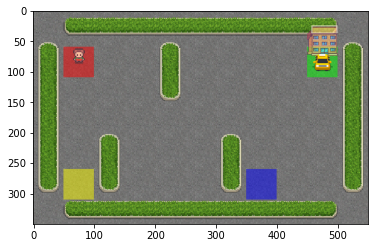

In [123]:
env.reset()
plt.imshow(env.render())

In [124]:
agent = QLearningAgent(
    alpha=0.5, epsilon=0.25, discount=0.99,
    get_legal_actions=lambda s: range(n_actions))

In [273]:
def play_and_train(env, agent, t_max=10**4):
    """
    This function should 
    - run a full game, actions given by agent's e-greedy policy
    - train agent using agent.update(...) whenever it is possible
    - return total reward
    """
    total_reward = 0.0
    s, _ = env.reset()

    for t in range(t_max):
        # get agent to pick action given state s.
        a = agent.get_action(s)

        next_s, r, done, _, _ = env.step(a)

        # train (update) agent for state s
        agent.update(s, a, r, next_s)

        s = next_s
        total_reward += r
        if done:
            break

    return total_reward

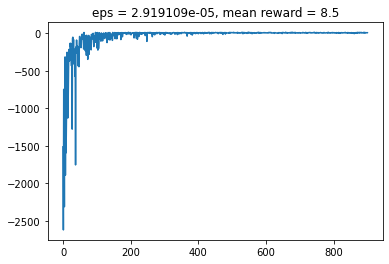

In [126]:
from IPython.display import clear_output

rewards = []
for i in range(1000):
    rewards.append(play_and_train(env, agent))
    agent.epsilon *= 0.99

    if i % 100 == 0:
        clear_output(True)
        plt.title('eps = {:e}, mean reward = {:.1f}'.format(agent.epsilon, np.mean(rewards[-10:])))
        plt.plot(rewards)
        plt.show()

# Binarized state spaces

Use agent to train efficiently on `CartPole-v0`. This environment has a continuous set of possible states, so you will have to group them into bins somehow.

The simplest way is to use `round(x, n_digits)` (or `np.round`) to round a real number to a given amount of digits. The tricky part is to get the `n_digits` right for each state to train effectively.

Note that you don't need to convert state to integers, but to __tuples__ of any kind of values.

first state: [ 0.01449265 -0.00168173  0.02925333 -0.01978002]


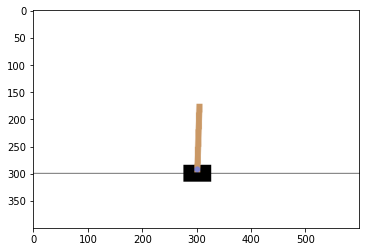

In [127]:
def make_env():
    return gym.make("CartPole-v1", render_mode="rgb_array").env  # .env unwraps the TimeLimit wrapper

env = make_env()
n_actions = env.action_space.n

s, _ = env.reset()
print(f"first state: {s}")
plt.imshow(env.render())

### Play a few games

We need to estimate observation distributions. To do so, we'll play a few games and record all states.

In [128]:
def visualize_cartpole_observation_distribution(seen_observations):
    seen_observations = np.array(seen_observations)
    
    # The meaning of the observations is documented in
    # https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py

    f, axarr = plt.subplots(2, 2, figsize=(16, 9), sharey=True)
    for i, title in enumerate(['Cart Position', 'Cart Velocity', 'Pole Angle', 'Pole Velocity At Tip']):
        ax = axarr[i // 2, i % 2]
        ax.hist(seen_observations[:, i], bins=20)
        ax.set_title(title)
        xmin, xmax = ax.get_xlim()
        ax.set_xlim(min(xmin, -xmax), max(-xmin, xmax))
        ax.grid()
    f.tight_layout()

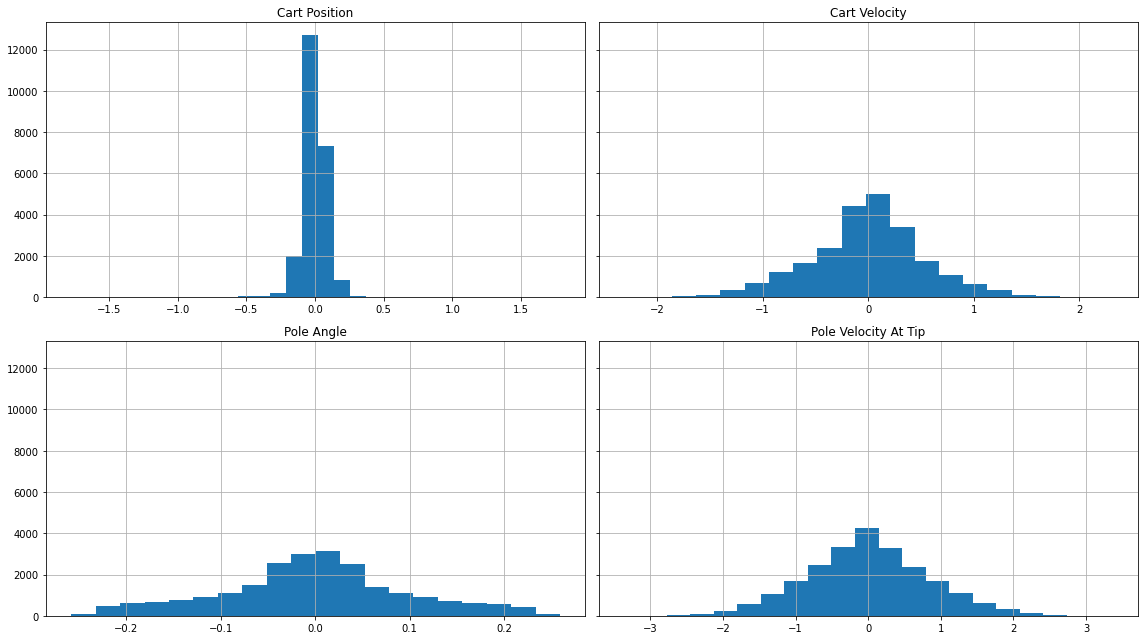

In [129]:
seen_observations = []
for _ in range(1000):
    seen_observations.append(env.reset()[0])
    done = False
    while not done:
        s, r, done, _, _ = env.step(env.action_space.sample())
        seen_observations.append(s)

visualize_cartpole_observation_distribution(seen_observations)

In [130]:
env.observation_space.low

array([-4.8000002e+00, -3.4028235e+38, -4.1887903e-01, -3.4028235e+38],
      dtype=float32)

In [131]:
env.observation_space.high

array([4.8000002e+00, 3.4028235e+38, 4.1887903e-01, 3.4028235e+38],
      dtype=float32)

In [136]:
observation_dim = env.observation_space.shape[0]

bins = (10, 10, 10, 10)
observation_distributions = np.array(seen_observations)
low = observation_distributions.min(axis=0)
high = observation_distributions.max(axis=0)
observation_bins = [np.linspace(start=low[i], stop=high[i], num=bins[i])
                                for i in range(observation_dim)]

## Binarize environment

In [137]:
class Binarizer(gym.ObservationWrapper):
    def observation(self, state):
        # Hint: use np.digitize
        obs = [int(np.digitize(x=np.clip([state_coord], low[i], high[i]), 
                              bins=bins))
               for i, (state_coord, bins) in enumerate(zip(state, observation_bins))]
        return tuple(obs)

In [138]:
digitized_env = Binarizer(make_env())

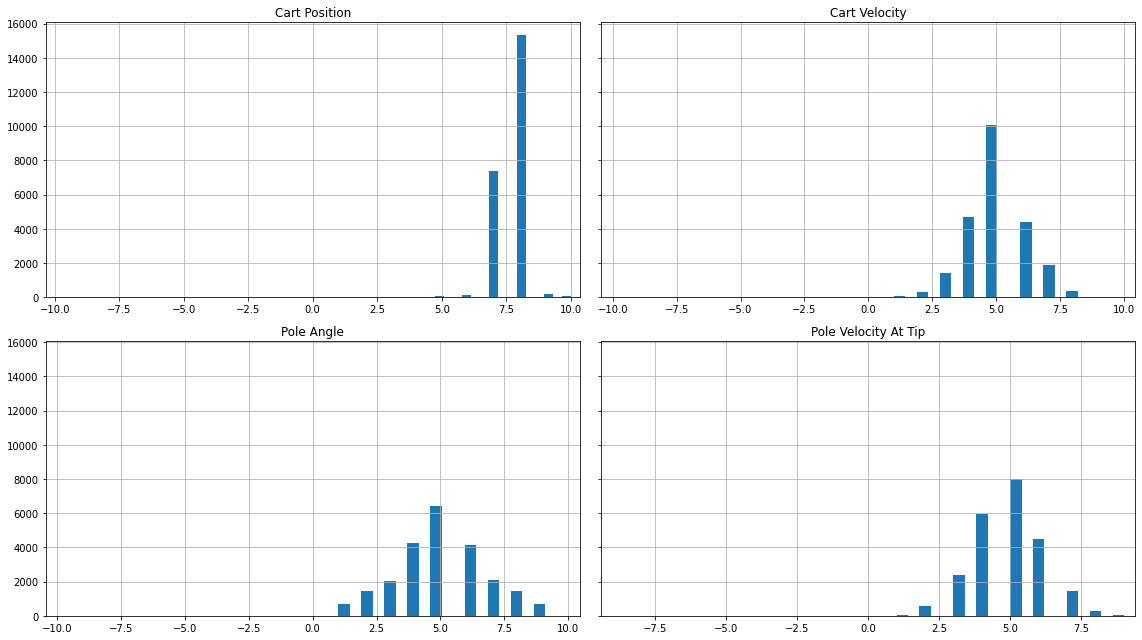

In [139]:
seen_digitized_observations = []
for _ in range(1000):
    seen_digitized_observations.append(digitized_env.reset()[0])
    done = False
    while not done:
        s, r, done, _, _ = digitized_env.step(digitized_env.action_space.sample())
        seen_digitized_observations.append(s)
        if done:
            break

visualize_cartpole_observation_distribution(seen_digitized_observations)

## Learn binarized policy

Now let's train a policy that uses binarized state space.

__Tips:__

* Note that increasing the number of digits for one dimension of the observations increases your state space by a factor of $10$.
* If your binarization is too fine-grained, your agent will take much longer than 10000 steps to converge. You can either increase the number of iterations and reduce epsilon decay or change binarization. In practice we found that this kind of mistake is rather frequent.
* If your binarization is too coarse, your agent may fail to find the optimal policy. In practice we found that on this particular environment this kind of mistake is rare.
* **Start with a coarse binarization** and make it more fine-grained if that seems necessary.
* Having $10^3$–$10^4$ distinct states is recommended (`len(agent._qvalues)`), but not required.
* If things don't work without annealing $\varepsilon$, consider adding that, but make sure that it doesn't go to zero too quickly.

A reasonable agent should attain an average reward of at least 50.

In [140]:
import pandas as pd

def moving_average(x, span=100):
    return pd.DataFrame({'x': np.asarray(x)}).x.ewm(span=span).mean().values

In [141]:
agent = QLearningAgent(
    alpha=0.5, epsilon=0.25, discount=0.99,
    get_legal_actions=lambda s: range(n_actions))

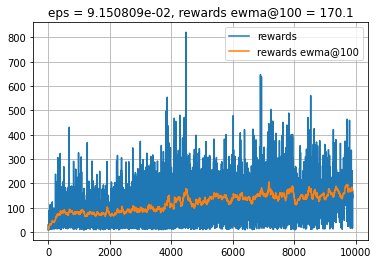

In [142]:
rewards = []
epsilons = []

for i in range(10000):
    reward = play_and_train(digitized_env, agent)
    rewards.append(reward)
    epsilons.append(agent.epsilon)
    
    # OPTIONAL: <YOUR CODE: adjust epsilon>

    if i % 100 == 0:
        agent.epsilon *= 0.99
        rewards_ewma = moving_average(rewards)
        
        clear_output(True)
        plt.plot(rewards, label='rewards')
        plt.plot(rewards_ewma, label='rewards ewma@100')
        plt.legend()
        plt.grid()
        plt.title('eps = {:e}, rewards ewma@100 = {:.1f}'.format(agent.epsilon, rewards_ewma[-1]))
        plt.show()

In [143]:
print('Your agent has learned {} Q-values.'.format(len(agent._qvalues)))

Your agent has learned 1787 Q-values.


## Expected SARSA

In [268]:
class EVSarsaAgent(QLearningAgent):
    """ 
    An agent that changes some of q-learning functions to implement Expected Value SARSA. 
    Note: this demo assumes that your implementation of QLearningAgent.update uses get_value(next_state).
    If it doesn't, please add
        def update(self, state, action, reward, next_state):
            and implement it for Expected Value SARSA's V(s')
    """

    def get_value(self, state):
        """ 
        Returns Vpi for current state under epsilon-greedy policy:
          V_{pi}(s) = sum _{over a_i} {pi(a_i | s) * Q(s, a_i)}

        Hint: all other methods from QLearningAgent are still accessible.
        """
        epsilon = self.epsilon
        possible_actions = self.get_legal_actions(state)

        # If there are no legal actions, return 0.0
        if not possible_actions:
            return 0.0

        policy = []

        epsilon = self.epsilon
        best_action = self.get_best_action(state)
        policy = [epsilon / len(possible_actions)] * len(possible_actions)
        policy[best_action] += 1 - epsilon    

        state_value = sum([policy[action] * self.get_qvalue(state, action) for action in possible_actions])

        return state_value

In [269]:
env = gym.make('CliffWalking-v0', render_mode="rgb_array")
n_actions = env.action_space.n

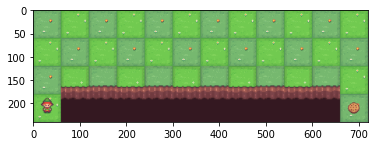

In [270]:
env.reset()
plt.imshow(env.render())

EVSARSA mean reward = -27.63
QLEARNING mean reward = -95.84


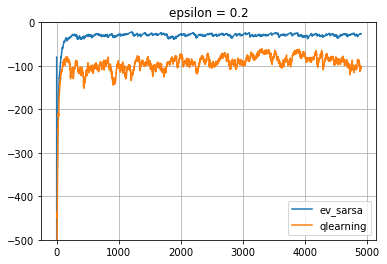

In [276]:
agent_sarsa = EVSarsaAgent(alpha=0.25, epsilon=0.2, discount=0.99,
                           get_legal_actions=lambda s: range(n_actions))

agent_ql = QLearningAgent(alpha=0.25, epsilon=0.2, discount=0.99,
                          get_legal_actions=lambda s: range(n_actions))

rewards_sarsa, rewards_ql = [], []

for i in range(5000):
    rewards_sarsa.append(play_and_train(env, agent_sarsa))
    rewards_ql.append(play_and_train(env, agent_ql))
    # Note: agent.epsilon stays constant

    if i % 100 == 0:
        clear_output(True)
        print('EVSARSA mean reward =', np.mean(rewards_sarsa[-100:]))
        print('QLEARNING mean reward =', np.mean(rewards_ql[-100:]))
        plt.title("epsilon = %s" % agent_ql.epsilon)
        plt.plot(moving_average(rewards_sarsa), label='ev_sarsa')
        plt.plot(moving_average(rewards_ql), label='qlearning')
        plt.grid()
        plt.legend()
        plt.ylim(-500, 0)
        plt.show()

In [278]:
def draw_policy(env, agent):
    """ Prints CliffWalkingEnv policy with arrows. Hard-coded. """
    n_rows, n_cols = env.shape

    actions = '^>v<'

    for yi in range(n_rows):
        for xi in range(n_cols):
            if env.unwrapped._cliff[yi, xi]:
                print(" C ", end='')
            elif (yi * n_cols + xi) == env.start_state_index:
                print(" X ", end='')
            elif (yi * n_cols + xi) == n_rows * n_cols - 1:
                print(" T ", end='')
            else:
                print(" %s " %
                      actions[agent.get_best_action(yi * n_cols + xi)], end='')
        print()

In [279]:
print("Q-Learning")
draw_policy(env, agent_ql)

print("SARSA")
draw_policy(env, agent_sarsa)

Q-Learning
 v  >  >  >  >  >  v  >  v  v  >  v 
 >  >  >  >  >  >  >  >  >  >  >  v 
 >  >  >  >  >  >  >  >  >  >  >  v 
 X  C  C  C  C  C  C  C  C  C  C  T 
SARSA
 >  >  >  >  >  >  >  >  >  >  >  v 
 ^  ^  ^  >  >  >  >  >  >  >  >  v 
 ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  >  v 
 X  C  C  C  C  C  C  C  C  C  C  T 


### Decreasing ɛ 

EVSARSA mean reward = -15.04
QLEARNING mean reward = -14.04


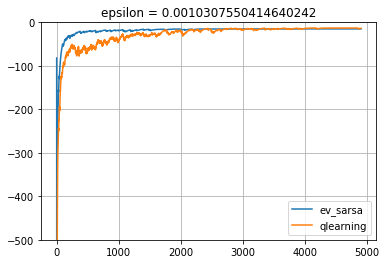

In [281]:
agent_sarsa = EVSarsaAgent(alpha=0.25, epsilon=0.2, discount=0.99,
                           get_legal_actions=lambda s: range(n_actions))

agent_ql = QLearningAgent(alpha=0.25, epsilon=0.2, discount=0.99,
                          get_legal_actions=lambda s: range(n_actions))

rewards_sarsa, rewards_ql = [], []

for i in range(5000):
    rewards_sarsa.append(play_and_train(env, agent_sarsa))
    rewards_ql.append(play_and_train(env, agent_ql))

    if i % 100 == 0:
        agent_sarsa.epsilon *= 0.9
        agent_ql.epsilon *= 0.9
        clear_output(True)
        print('EVSARSA mean reward =', np.mean(rewards_sarsa[-100:]))
        print('QLEARNING mean reward =', np.mean(rewards_ql[-100:]))
        plt.title("epsilon = %s" % agent_ql.epsilon)
        plt.plot(moving_average(rewards_sarsa), label='ev_sarsa')
        plt.plot(moving_average(rewards_ql), label='qlearning')
        plt.grid()
        plt.legend()
        plt.ylim(-500, 0)
        plt.show()

In [282]:
print("Q-Learning")
draw_policy(env, agent_ql)

print("SARSA")
draw_policy(env, agent_sarsa)

Q-Learning
 ^  <  >  >  >  ^  >  >  >  >  >  v 
 v  v  >  >  v  >  >  v  v  >  v  v 
 >  >  >  >  >  >  >  >  >  >  >  v 
 X  C  C  C  C  C  C  C  C  C  C  T 
SARSA
 >  >  >  >  >  >  >  >  >  >  >  v 
 >  >  >  >  >  >  >  >  >  >  >  v 
 ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  >  v 
 X  C  C  C  C  C  C  C  C  C  C  T 
